In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("netflix_titles.csv")
df.head(2)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."


## A. Data Cleaning

### 1. Removing Unnecessary Columns

In [5]:
df.drop(columns=["director", "cast", "date_added", "description"], inplace=True)

### 2. Changing Data Type

In [7]:
df.dtypes

show_id         object
type            object
title           object
country         object
release_year     int64
rating          object
duration        object
listed_in       object
dtype: object

### a. "duration" column to integer

In [9]:
df["duration"] = df["duration"].str.replace("seasons|season|min", "", regex=True, case=False)
df["duration"] = df["duration"].str.strip()
df["duration"] = pd.to_numeric(df["duration"])

### 3. Handling Duplicated Value

In [11]:
df.duplicated().sum()

0

### 4. Handling Missing Value

In [13]:
df.isna().sum()

show_id           0
type              0
title             0
country         831
release_year      0
rating            4
duration          3
listed_in         0
dtype: int64

### a. Removing NaN values in the "country" column

In [15]:
df = df[~(df["country"].isna())]

### b. Labeling NaN values in the "rating" column as "NR"

In [17]:
df["rating"] = df["rating"].fillna("NR")

### c. Handling NaN values in the "duration" column with it's median

In [19]:
df[(df["type"] == "Movie") & (df["duration"].isna())]

,show_id,type,title,country,release_year,rating,duration,listed_in
5541,s5542,Movie,Louis C.K. 2017,United States,2017,74 min,NaN,Movies
5794,s5795,Movie,Louis C.K.: Hilarious,United States,2010,84 min,NaN,Movies
5813,s5814,Movie,Louis C.K.: Live at the Comedy Store,United States,2015,66 min,NaN,Movies


In [20]:
df["duration"] = df["duration"].fillna(df["duration"].median())

In [21]:
# recheck the NaN for all columns
df.isna().sum()

show_id         0
type            0
title           0
country         0
release_year    0
rating          0
duration        0
listed_in       0
dtype: int64

### 6. Removing whitespace from all columns

In [23]:
df.dtypes

show_id          object
type             object
title            object
country          object
release_year      int64
rating           object
duration        float64
listed_in        object
dtype: object

In [24]:
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)

## B. Data Preprocessing

### 1. Categorizing the rating for better readibility

In [27]:
rating = set(df["rating"].unique())
rating

{'66 min',
 '74 min',
 '84 min',
 'G',
 'NC-17',
 'NR',
 'PG',
 'PG-13',
 'R',
 'TV-14',
 'TV-G',
 'TV-MA',
 'TV-PG',
 'TV-Y',
 'TV-Y7',
 'TV-Y7-FV',
 'UR'}

In [28]:
# there's abnormality where rating is a duration, thus we replace it with "NR"
df["rating"] = df["rating"].replace(["66 min", "74 min", "84 min"], "NR")

In [29]:
rating_map = {
    'G': "General Audience",
    'NC-17': "Adult",
    'NR': "Not Rated",
    'PG': "Parental Guidance",
    'PG-13': "Parental Guidance",
    'R': "Adult",
    'TV-14': "Teen",
    'TV-G': "General Audience",
    'TV-MA': "Adult",
    'TV-PG': "Parental Guidance",
    'TV-Y': "Kids",
    'TV-Y7': "Kids",
    'TV-Y7-FV': "Parental Guidance",
    'UR': "Not Rated"
}

df["rating"] = df["rating"].map(rating_map)

### 2. Simplify genres by categorizing them

In [31]:
genre_map = {
    "Action & Adventure": ["TV Action & Adventure", "Action & Adventure"],
    "Anime": ["Anime Features", "Anime Series"],
    "Children & Family": ["Children & Family Movies", "Kids' TV"],
    "Classic & Cult": ["Classic Movies", "Cult Movies", "Classic & Cult TV"],
    "Comedy": ["TV Comedies", "Comedies", "Stand-Up Comedy & Talk Shows", "Stand-Up Comedy"],
    "Crime": ["Crime Movies", "Crime TV Shows"],
    "Documentary": ["Documentaries", "Docuseries", "Science & Nature TV"],
    "Drama": ["TV Dramas", "Dramas"],
    "Horror": ["Horror Movies", "TV Horror"],
    "Independent": ["Independent Movies"],
    "International": ["International Movies", "International TV Shows"],
    "LGBTQ": ["LGBTQ Movies"],
    "Music": ["Music & Musicals"],
    "Reality": ["Reality TV"],
    "Romance": ["Romantic Movies", "Romantic TV Shows"],
    "Sci-Fi & Fantasy": ["TV Sci-Fi & Fantasy"],
    "Spanish-Language": ["Spanish-Language TV Shows"],
    "Sports": ["Sports Movies"],
    "Teen": ["Teen TV Shows"],
    "Thriller": ["TV Thrillers", "Thrillers", "TV Mysteries"]
}

for key, values in genre_map.items():
    for value in values:
        df["listed_in"] = df["listed_in"].str.replace(value, key)

### 3. Counting the content types
**For plot (1)**

In [33]:
content_type_count = df["type"].value_counts().reset_index()

### 4.  Dividing the dataframe into 2 types: TV Show and Movie

In [35]:
# tv show
df_tvshow = df[df["type"] == "TV Show"].reset_index(drop=True)

# movie
df_movie =  df[df["type"] == "Movie"].reset_index(drop=True)

### 5. Counting countries
**For plot (2)**

It is known that **some TV shows or movies have more than 1 country of origin** (a co-production).

In [38]:
len(df[df["country"].str.split(", ").str.len() > 1])

1316

So we **split and count each one** for each country.

In [40]:
df_duplicate = df.copy()
df_duplicate["country"] = df_duplicate["country"].str.split(", ")
df_country = df_duplicate.explode("country")
df_country = df_country[["show_id", "type", "country"]]

In [41]:
# tv show
tvshow_country_count = df_country[df_country["type"] == "TV Show"]["country"].value_counts().reset_index()

# movie
movie_country_count = df_country[df_country["type"] == "Movie"]["country"].value_counts().reset_index()

### 6. Counting year
**For plot (3)**

In [43]:
year_count = df.groupby(["type", "release_year"]).size().reset_index()
year_count.columns = ["type", "release_year", "count"]

### 7. Counting the content rating
**For plot (4)**

In [45]:
# tv show
rating_tvshow_count = df_tvshow["rating"].value_counts().reset_index()
rating_tvshow_count.columns = ["rating", "count"]

# movie
rating_movie_count = df_movie["rating"].value_counts().reset_index()
rating_movie_count.columns = ["rating", "count"]

### 8. Categorizing by genre
**For plot (5)**

In [47]:
# tv show
df_genre_tvshow = df_tvshow["listed_in"].str.get_dummies(sep=", ")
genre_tvshow_count = df_genre_tvshow.sum().sort_values(ascending=False).reset_index()
genre_tvshow_count.columns = ["genre", "count"]

# movie
df_genre_movie = df_movie["listed_in"].str.get_dummies(sep=", ")
genre_movie_count = df_genre_movie.sum().sort_values(ascending=False).reset_index()
genre_movie_count.columns = ["genre", "count"]

## C. Visualization

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

### (1) Distribution of Content Types

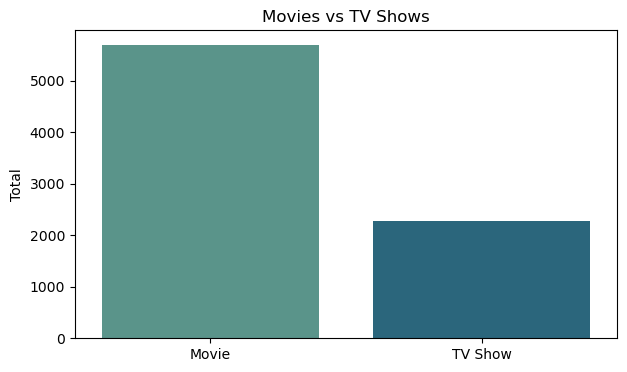

In [51]:
plt.figure(figsize=(7,4))
sns.barplot(x="type", y="count", data=content_type_count, hue="type", palette="crest")
plt.title("Movies vs TV Shows")
plt.xlabel("")
plt.ylabel("Total")
plt.show()

The bar plot reveals a significant imbalance in the total count of movies and TV shows, with movies dominating the dataset at over 5000 entries compared to nearly 2500 TV shows. This indicates a stronger focus on movie distribution by Netflix over the years.
**But**, it is important to note that each TV show is counted as a single title regardless of its number of seasons, which can include multiple episodes, while a movie is counted individually.

### (2) Top 5 Country of Origin by Content

**TV Show**

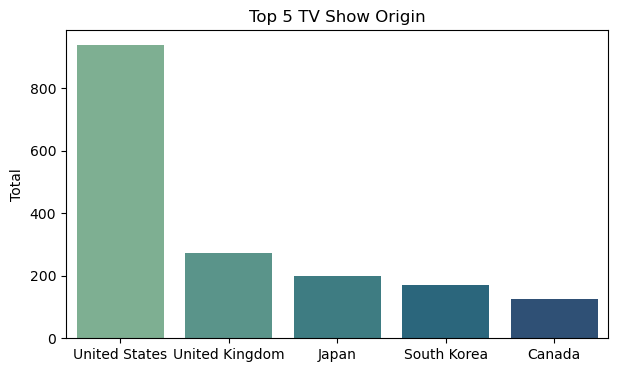

In [55]:
plt.figure(figsize=(7,4))
sns.barplot(x="country", y="count", data=tvshow_country_count.head(5), hue="country", palette="crest")
plt.title("Top 5 TV Show Origin")
plt.xlabel("")
plt.ylabel("Total")
plt.show()

**Movie**

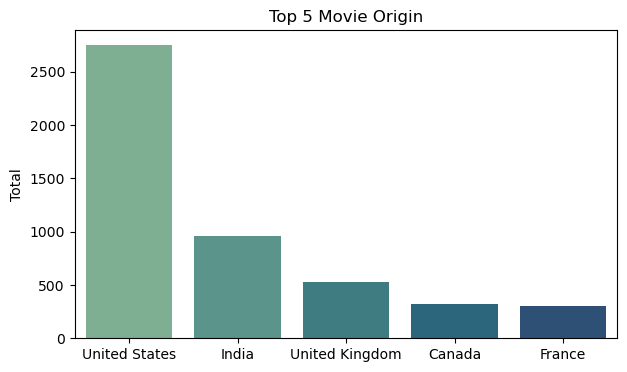

In [57]:
plt.figure(figsize=(7,4))
sns.barplot(x="country", y="count", data=movie_country_count.head(5), hue="country", palette="crest")
plt.title("Top 5 Movie Origin")
plt.xlabel("")
plt.ylabel("Total")
plt.show()

The bar plots for TV shows and movies highlight the United States as the leading contributor in both categories. For TV shows, it surpasses 800, around 900, counts, followed by the UK, Japan, South Korea, and Canada. In movies, the U.S. accounts for over 2,500, with India coming in second at nearly 1,000, and the UK, Canada, and France trailing behind.

### (3) Number of Releases Over Time

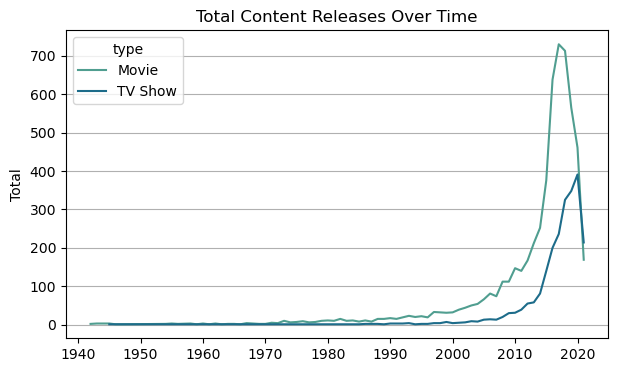

In [60]:
plt.figure(figsize=(7,4))
sns.lineplot(x="release_year", y="count", data=year_count, hue="type", palette="crest")
plt.title("Total Content Releases Over Time")
plt.xlabel("")
plt.ylabel("Total")
plt.grid(axis="y")
plt.show()

The line plot illustrates a notable trend in content releases from 1942 to 2020. Both movies and TV shows show a consistent increase, peaking in 2017 for movies and 2020 for TV shows, followed by a decline in subsequent years.

### (4) Distribution of Content Ratings

**TV Show**

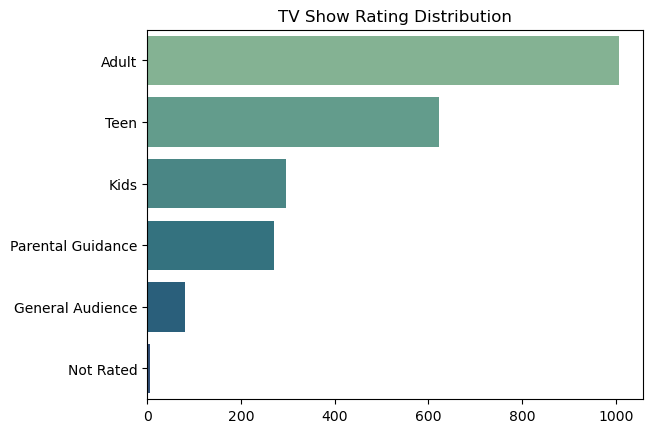

In [64]:
sns.barplot(x="count", y="rating", data=rating_tvshow_count, hue="rating", palette="crest")
plt.title("TV Show Rating Distribution")
plt.xlabel("")
plt.ylabel("")
plt.show()

**Movie**

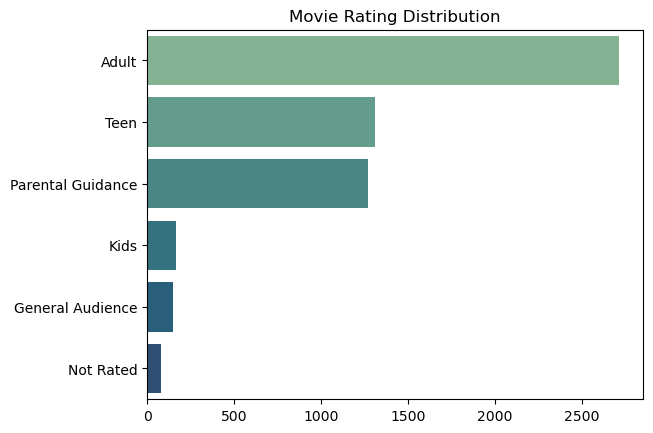

In [66]:
sns.barplot(x="count", y="rating", data=rating_movie_count, hue="rating", palette="crest")
plt.title("Movie Rating Distribution")
plt.xlabel("")
plt.ylabel("")
plt.show()

The horizontal bar plots indicate a preference for adult-rated content in both TV shows (at almost 1000) and movies (for over 2500) in total. Teen ratings also show significant representation, especially in movies, while other ratings like kids and general audience are less common.

### (5) Top 5 Genres by Frequency

**TV Show**

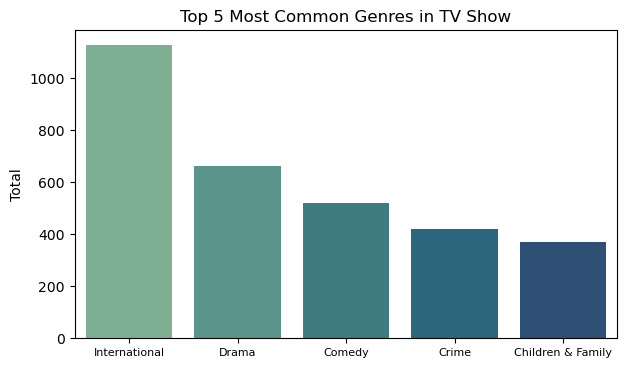

In [70]:
plt.figure(figsize=(7,4))
sns.barplot(x="genre", y="count", data=genre_tvshow_count.head(5), hue="genre", palette="crest")
plt.title("Top 5 Most Common Genres in TV Show")
plt.xlabel("")
plt.xticks(fontsize=8)
plt.ylabel("Total")
plt.show()

**Movie**

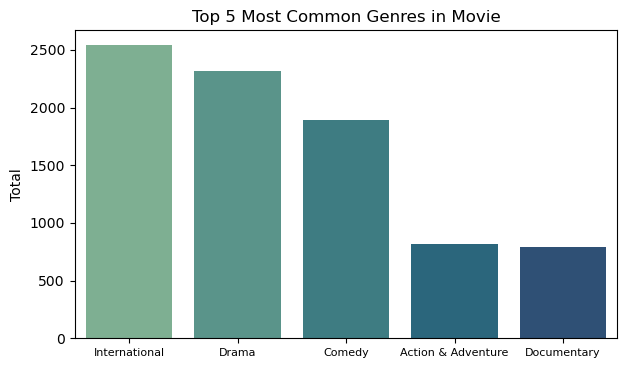

In [72]:
plt.figure(figsize=(7,4))
sns.barplot(x="genre", y="count", data=genre_movie_count.head(5), hue="genre", palette="crest")
plt.title("Top 5 Most Common Genres in Movie")
plt.xlabel("")
plt.xticks(fontsize=8)
plt.ylabel("Total")
plt.show()

The bar plot analysis indicates that "International" genre is the most frequent genre in both TV shows and movie content, nearing 1100 counts for TV shows and at around 2500 counts for movie. Other genres like dramas and comedies also show strong representation in both categories.

### (6) Distribution of Durations

**TV Show**

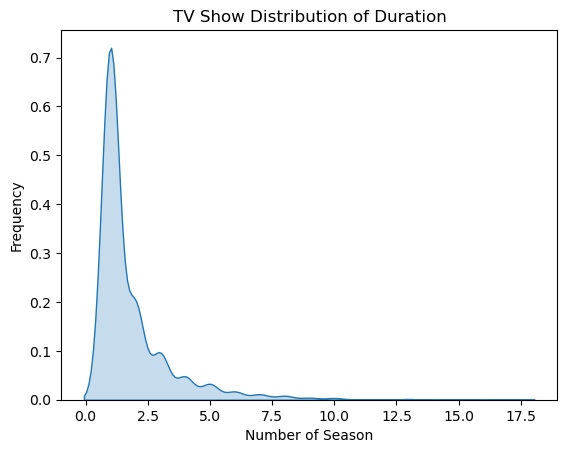

In [76]:
sns.kdeplot(df_tvshow["duration"], fill=True)
plt.title("TV Show Distribution of Duration")
plt.xlabel("Number of Season")
plt.ylabel("Frequency")
plt.show()

**Movie**

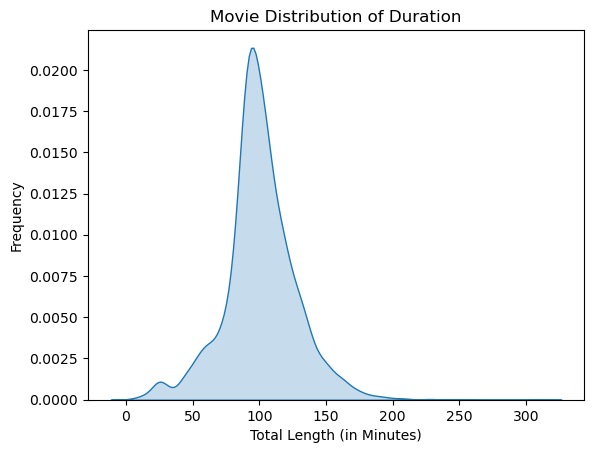

In [78]:
sns.kdeplot(df_movie["duration"], fill=True)
plt.title("Movie Distribution of Duration")
plt.xlabel("Total Length (in Minutes)")
plt.ylabel("Frequency")
plt.show()

The KDE plots suggest that TV shows typically last about 1 to 2 seasons, peaking in frequency, while movies tend to have an average duration of about 100 minutes.

### 3.5. Helper

In [81]:
df.to_csv("netflix_clean.csv", index=False)

In [82]:
dummy = df["listed_in"].str.get_dummies(sep=", ")
dummy = dummy.map(lambda x: bool(x))
df_genre = pd.concat([df["show_id"], dummy], axis=1)

df_genre.to_csv("netflix_genre.csv", index=False)

In [83]:
df_country[["show_id", "country"]].to_csv("netflix_country.csv", index=False)

In [84]:
df_tvshow[["show_id", "duration"]].to_csv("netflix_tvshow_duration.csv", index=False)
df_movie[["show_id", "duration"]].to_csv("netflix_movie_duration.csv", index=False)

### 4. Dashboard

Making dashboard using *Tableau*

In [87]:
import webbrowser

url = "https://public.tableau.com/app/profile/erich.dewantara/viz/ExploringNetflixContentTrendReports/Dashboard1"
webbrowser.open(url)

True